You’ve heard of decision trees, right? They help break down decisions step-by-step. Now, what if I told you there’s a way to take those decision trees and make them even more powerful? That’s where Gradient Boosting Algorithms come in!

**The Basic Idea of Gradient Boosting:** Imagine this: you’re learning how to shoot hoops. You miss your first shot, but instead of giving up, you learn from that mistake. The next time, you adjust your angle a bit, and slowly, your shots get better. That’s basically how Gradient Boosting works — it improves by learning from its mistakes!

### **Let’s Meet the Gradient Boosting Family- Introducing LightGBM**

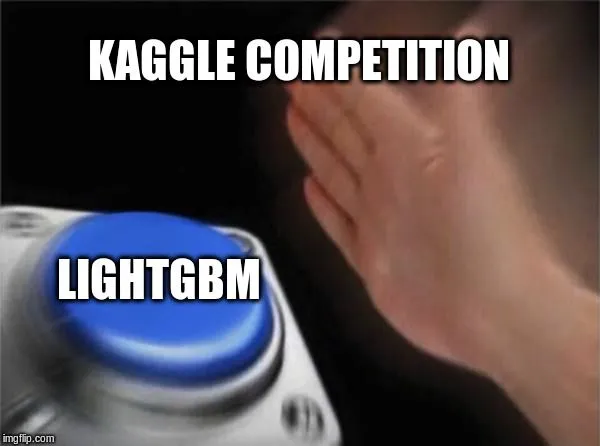

### **LightGBM (Light Gradient Boosting Machine)**
LightGBM is all about efficiency and speed, especially when you have huge datasets. It’s designed to handle millions of data points quickly.

LightGBM uses something called leaf-wise growth. **Instead of growing the tree level by level, it grows the leaves that reduce error the most,** which makes it faster and more accurate.
It’s super-efficient and can handle really large datasets with ease. It’s also very memory-efficient.

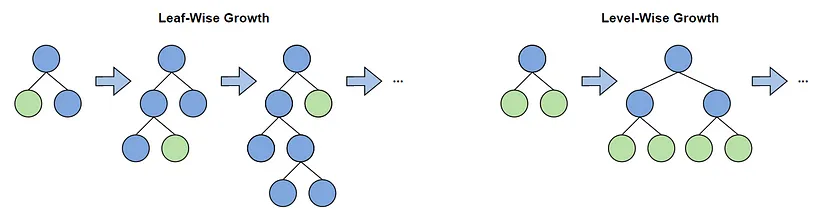

In [1]:
import numpy as np

# Decision stump used as weak classifier
class DecisionStump:
    def __init__(self):
        self.feature_idx = None
        self.threshold = None
        self.left_value = None
        self.right_value = None

    def predict(self, X):
        predictions = np.ones(X.shape[0])
        feature_values = X[:, self.feature_idx]
        predictions[feature_values <= self.threshold] = self.left_value
        predictions[feature_values > self.threshold] = self.right_value
        return predictions

class LightGBM:
    def __init__(self, n_estimators=10, learning_rate=0.1, max_bin=255):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_bin = max_bin
        self.trees = []

    def fit(self, X, y):
        n_samples, n_features = X.shape
        predictions = np.zeros(n_samples)

        # Bin the data into discrete values for LightGBM-style learning
        binned_X = self._bin_data(X)

        for _ in range(self.n_estimators):
            residuals = y - predictions

            # Train a weak learner on residuals
            stump = DecisionStump()
            min_error = float("inf")

            for feature_i in range(n_features):
                feature_values = binned_X[:, feature_i]
                thresholds = np.unique(feature_values)

                for threshold in thresholds:
                    left_value = np.mean(residuals[feature_values <= threshold])
                    right_value = np.mean(residuals[feature_values > threshold])

                    stump_predictions = np.where(feature_values <= threshold, left_value, right_value)
                    error = np.sum((residuals - stump_predictions) ** 2)

                    if error < min_error:
                        min_error = error
                        stump.feature_idx = feature_i
                        stump.threshold = threshold
                        stump.left_value = left_value
                        stump.right_value = right_value

            # Update predictions
            predictions += self.learning_rate * stump.predict(binned_X)

            # Save the trained stump
            self.trees.append(stump)

    def predict(self, X):
        binned_X = self._bin_data(X)
        y_pred = np.zeros(binned_X.shape[0])
        for stump in self.trees:
            y_pred += self.learning_rate * stump.predict(binned_X)
        return np.sign(y_pred)

    def _bin_data(self, X):
        """Bins the data into discrete values for LightGBM-style gradient boosting."""
        n_samples, n_features = X.shape
        binned_X = np.zeros_like(X, dtype=int)

        for feature_i in range(n_features):
            feature_values = X[:, feature_i]
            min_val, max_val = feature_values.min(), feature_values.max()
            bins = np.linspace(min_val, max_val, self.max_bin + 1)
            binned_X[:, feature_i] = np.digitize(feature_values, bins) - 1

        return binned_X


In [2]:

# Testing
if __name__ == "__main__":
    # Imports
    from sklearn import datasets
    from sklearn.model_selection import train_test_split

    def accuracy(y_true, y_pred):
        return np.sum(y_true == y_pred) / len(y_true)

    # Load dataset
    data = datasets.load_breast_cancer()
    X, y = data.data, data.target

    # Convert targets to {-1, 1} for binary classification
    y[y == 0] = -1

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

    # LightGBM classification with 10 weak classifiers
    clf = LightGBM(n_estimators=10, learning_rate=0.1, max_bin=255)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    acc = accuracy(y_test, y_pred)
    print("Accuracy:", acc)


c:\Users\40107588\Desktop\ML- Code from Scratch\ml_env\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\40107588\Desktop\ML- Code from Scratch\ml_env\Lib\site-packages\numpy\_core\_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Accuracy: 0.9122807017543859
